In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
from collections import deque

# Feature Engineering
features:
FG per game by shot

In [81]:
df = pd.read_csv('../data/data1.csv')


In [82]:
def last_5_average(df):
    """
    Create a "moving average" for the points scored in the last 5 games.
    :param df:
    :return:
    """
    df = df.sort_values(by=['game_date'])
    df['last_5_games_avg'] = ""

    average_per_game = df.groupby(['game_id'], sort=False)['shot_made_flag'].mean().reset_index(name="avg")
    avg_pts = deque(maxlen=5) # using a queue with a max number of elements

    prev_res = 0
    for i, game, avg in average_per_game.itertuples():
        avg_pts.append(avg)
        res = round(sum(avg_pts) / len(avg_pts),2) # max size will be 5. for the first 5 we divide by the length of the array.
        if i == 0:
            # we skip the first
            df.loc[df['game_id'] == game, ['last_5_games_avg']] = 0
        else:
            df.loc[df['game_id'] == game, ['last_5_games_avg']] = prev_res

        prev_res = res

    return df


In [83]:
# shot id is needed. we can delete it later
def before_current_shot_features(df):
    """
    Adding the statistics for the shots taken before the current shot
    :param df:
    :return:
    """
    df['streak_before_shot'] = ""
    df['points_before_shot'] = ""
    df['fgp_before_shot'] = ""

    for game in df.game_id.unique():
        fgp = [0,0]
        streak = 0
        shots = df[df['game_id'] == game]['shot_id'].sort_values()
        prev_streak = 0
        points = 0
        prev_points = 0
        for num, shot in enumerate(shots):

            row = df[(df['game_id'] == game) & (df['shot_id'] == shot)]

            flag = row['shot_made_flag'].item()
            shot_type = row['shot_type'].item()
            period = row['period'].item()

            # TODO divide per period somehow and multiply by the time remaining
            if num == 0:
                df.loc[(df['game_id']==game) & (df['shot_id'] == shot), ['fgp_before_shot'] ] = 0.00
            else:
                df.loc[(df['game_id']==game) & (df['shot_id'] == shot), ['fgp_before_shot'] ] = round(fgp[0]/fgp[1],2)

            fgp[1] += 1
            if flag == 1.0:
                fgp[0] += 1
                prev_streak = streak
                prev_points = points
                streak += 1

                if shot_type == '2PT Field Goal':
                    points += 2
                else:
                    points += 3
            else:
                prev_streak = streak
                prev_points = points
                streak = 0

            # df.loc[(df['game_id']==game) & (df['shot_id'] == shot), ['current_streak'] ] = streak
            df.loc[(df['game_id']==game) & (df['shot_id'] == shot), ['streak_before_shot'] ] = prev_streak
            df.loc[(df['game_id']==game) & (df['shot_id'] == shot), ['points_before_shot'] ] = prev_points

    return df

Extracting the month, players shoot differently depending on the month

In [84]:
def extract_month(df):
    """
    Extract the month from the datetime format.
    :param df: dataframe
    :return: modified df with the month feature
    """
    df['month'] = df.game_date.apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").month)
    return df


In [85]:
# get points scored per game
# shot_type = '2PT Field Goal'
# shot_made_flag 1.0 0.0
# df[df.game_id == 20000012].apply(lambda x: x['shot_type'], axis=1)

def feature_engineering(df):
    """
    Do the feature engineering on the dataframe
    :param df: original dataset
    :return: copy of the original but with modificaiton.
    """
    df_new = df.copy(deep=True)
    df_new = last_5_average(df_new)
    df_new = before_current_shot_features(df_new)
    df_new = extract_month(df_new)
    return df_new

In [86]:
df = feature_engineering(df)

In [87]:
df.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,period,playoffs,...,game_date,matchup,opponent,shot_id,time_remaining,last_5_games_avg,streak_before_shot,points_before_shot,fgp_before_shot,month
19214,Jump Shot,Jump Shot,102,29600027,33.9283,-140,116,-118.4098,1,0,...,1996-11-03,home,MIN,22902,42,0,0,0,0.0,11
19215,Jump Shot,Jump Shot,127,29600031,33.9473,-131,97,-118.4008,2,0,...,1996-11-05,away,NYK,22903,608,0.0,0,0,0.0,11
19216,Jump Shot,Jump Shot,124,29600044,33.8633,-142,181,-118.4118,2,0,...,1996-11-06,away,CHA,22904,517,0.0,0,0,0.0,11
19217,Jump Shot,Jump Shot,144,29600044,34.0443,0,0,-118.2698,2,0,...,1996-11-06,away,CHA,22905,394,0.0,1,3,1.0,11
19218,Jump Shot,Jump Shot,151,29600044,33.9063,-10,138,-118.2798,2,0,...,1996-11-06,away,CHA,22906,327,0.0,0,3,0.5,11


<AxesSubplot:xlabel='season', ylabel='FGP'>

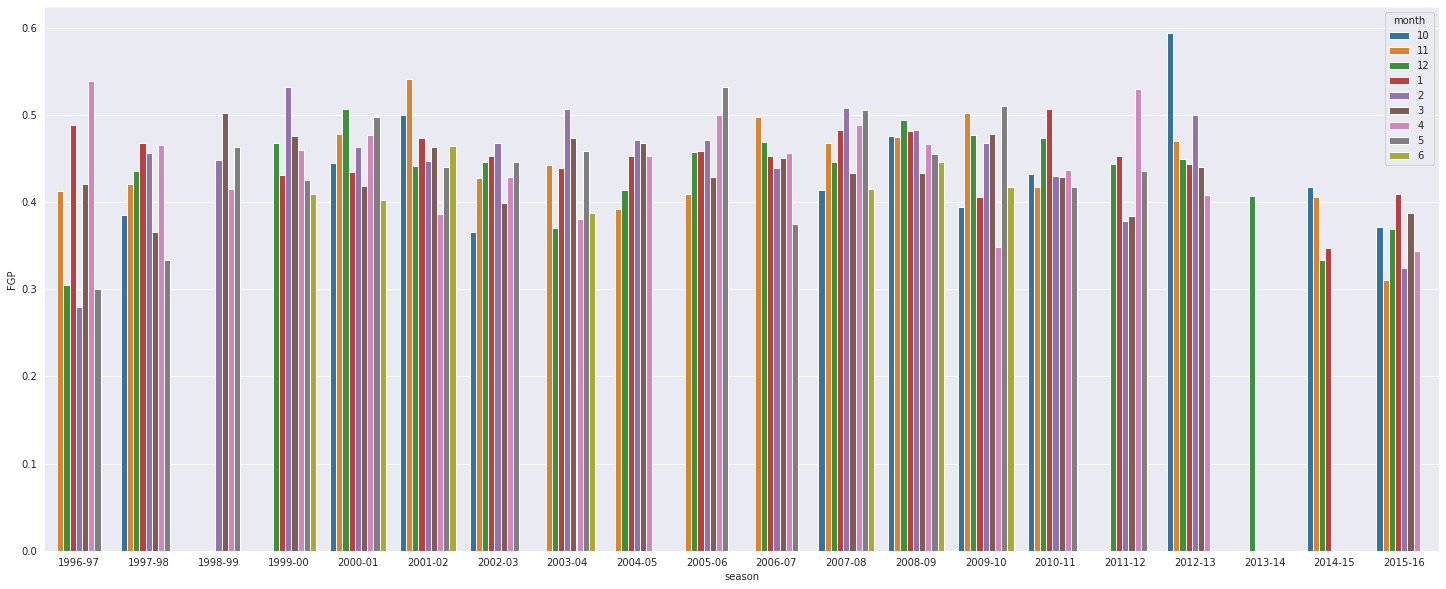

In [92]:
plt.figure(figsize=(25,10))
df_fgp = df.groupby(['season', 'month'])['shot_made_flag'].mean().reset_index(name='FGP')
sns.barplot(data=df_fgp, x='season', y='FGP', hue='month',ci=None, hue_order=[10,11,12,1,2,3,4,5,6])

FGP per game in a season

In [16]:
# we don't use this statistics anymore. Maybe come up with something different?
# df.to_csv('../data/data2.csv', index=False)# df_pm = df[['season', 'plus_minus', 'game_date']].drop_duplicates()
# g = sns.FacetGrid(df_pm, col="season", col_wrap=2, size=4, aspect=2)
# g.map(sns.barplot,'game_date', 'plus_minus', data=df_pm)